In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig
from asgardpy.data.target import apply_selection_mask_to_models, set_models

from gammapy.maps import Map
from gammapy.modeling.models import Models
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.datasets import Datasets

In [2]:
os.environ['GAMMAPY_DATA']

'/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/'

In [3]:
log = logging.getLogger("test DL4 steps")

In [4]:
config_file = "../asgardpy/tests/config_test_base.yaml"

In [5]:
config = AsgardpyConfig()

In [6]:
%%time
config_main = config.read(config_file)

CPU times: user 25.2 ms, sys: 4.42 ms, total: 29.7 ms
Wall time: 40.3 ms


# Update path of test data

In [7]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [8]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename='', filemode='w', format='', datefmt=''))
('outdir', PosixPath('.'))
('n_jobs', 10)
('parallel_backend', <ParallelBackendEnum.multi: 'multiprocessing'>)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [9]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

In [10]:
for c in config_main.target:
    print(c)

('source_name', '4FGL J0534.5+2201i')
('sky_position', SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>))
('use_uniform_position', True)
('models_file', PosixPath('.'))
('add_fov_bkg_model', False)
('use_catalog', CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>))
('components', [SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='domingu

# Datasets informations

In [11]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', input_dl3=[InputDL3Config(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'events': '*ft*.fits*', 'edisp': 'drm*.fits*', 'xml_model': 'srcmdl*.xml', 'exposure': 'bexpmap*.fits*', 'psf': 'psf*.fits*'}), InputDL3Config(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'gal_diffuse': 'gll_iem_v07_cutout.fits*', 'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'})], input_dl4=False, dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['00', '01'], observation=ObservationsConfig(obs_ids=[], obs_file=PosixPath('.'), obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='mjd' value=0.0>, stop=<Time object: scale='utc' format='mjd' value=0.0>)])

In [12]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='HESS', input_dl3=[InputDL3Config(type='gadf-dl3', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1'), glob_pattern={'dl3': 'data/hess_*fits.gz'})], input_dl4=False, dataset_info=Dataset1DInfoConfig(name='HESS', geom=GeomConfig(wcs=WcsConfig(skydir=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 0. deg>, lat=<Angle 0. deg>, radius=<Angle 0. deg>), binsize=<Angle 0.02 deg>, proj=<ProjectionEnum.tan: 'TAN'>, map_frame_shape=MapFrameShapeConfig(width=<Angle 6. deg>, height=<Angle 6. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=[MapAxesConfig(name='energy', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV')), MapAxesConfig(name='energy_true', axis=EnergyAxisConfig(min=<Quanti

# DL4 step information

In [13]:
for cc in config_main.fit_params:
    print(cc)

('fit_range', EnergyRangeConfig(min=<Quantity 1. GeV>, max=<Quantity 40. TeV>))
('backend', <BackendEnum.minuit: 'minuit'>)
('optimize_opts', {})
('covariance_opts', {})
('confidence_opts', {})
('store_trace', True)


In [14]:
for cc in config_main.flux_points_params:
    print(cc)

('parameters', {'selection_optional': 'all'})
('reoptimize', False)


In [15]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 1.4 ms, sys: 518 µs, total: 1.92 ms
Wall time: 1.41 ms


In [16]:
analysis

# Prepare the dataset

In [18]:
instruments_list_3d = config_main.dataset3d.instruments
print(len(instruments_list_3d), "number of 3D dataset information provided")

config_3d_dataset = instruments_list_3d[0]
print(f"Instrument selected is {config_3d_dataset.name}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [19]:
instruments_list_1d = config_main.dataset1d.instruments
print(len(instruments_list_1d), "number of 1D dataset information provided")

config_1d_dataset = instruments_list_1d[0]
print(f"Instrument selected is {config_1d_dataset.name}")

1 number of 1D dataset information provided
Instrument selected is HESS


In [20]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['00', '01']


# Run each Dataset nD Generation step

In [21]:
%%time
analysis.run(["datasets-3d"])

Perform DL3 to DL4 process!
1 number of 3D Datasets given
The different keys used: 00 01
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.
Using the exclusion mask to create a safe mask
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astr

CPU times: user 12.3 s, sys: 303 ms, total: 12.6 s
Wall time: 18.2 s


## Display some results

In [22]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637', '4FGL J0552.0+2656c', '4FGL J0601.4+2320', '4FGL J0509.1+1943', '4FGL J0533.9+2838', '4FGL J0519.6+2744', '4FGL J0603.9+2159', '4FGL J0510.0+1800', '4FGL J0524.5+2839', '4FGL J0533.5+1449', '4FGL J0539.6+1432', '4FGL J0515.8+1527', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637',

In [23]:
print(analysis.final_model)

Models

Component 0: SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi               

In [24]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.

In [25]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT'], 'spectral_energy_ranges': [<Quantity [  1.        ,   1.77827941,   3.16227766,   5.62341325,
            10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
           100.        , 177.827941  , 316.22776602, 562.34132519] GeV>], 'en_bins': 48, 'free_params': 8, 'DoF': 40}


In [26]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01']


In [27]:
%%time
analysis.run(["datasets-1d"])

Perform DL3 to DL4 process!
1 number of 1D Datasets given
Observation ID list selected: 23523 23526 23559 23592
Observations selected: 4 out of 4.
Using 4 processes to compute Data reduction
Computing dataset for observation 23526
Running SpectrumDatasetMaker
Computing dataset for observation 23559
Computing dataset for observation 23523
Running SpectrumDatasetMaker
Running SpectrumDatasetMaker
Computing dataset for observation 23592
Running SpectrumDatasetMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Analysis Step datasets-1d completed
Models have been associated with the Datasets


CPU times: user 286 ms, sys: 81 ms, total: 367 ms
Wall time: 1.42 s


## Display the results

In [28]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637', '4FGL J0552.0+2656c', '4FGL J0601.4+2320', '4FGL J0509.1+1943', '4FGL J0533.9+2838', '4FGL J0519.6+2744', '4FGL J0603.9+2159', '4FGL J0510.0+1800', '4FGL J0524.5+2839', '4FGL J0533.5+1449', '4FGL J0539.6+1432', '4FGL J0515.8+1527', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637',

In [29]:
for d in analysis.datasets:
    print(d)

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 43612 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 40304.93
  Predicted background counts     : nan
  Predicted excess counts         : 40304.93

  Exposure min                    : 5.73e+10 cm2 s
  Exposure max                    : 7.35e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 480912 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 127794.77

  Number of models                : 25 
  Number of parameters            : 132
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal 

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 42932 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 39710.81
  Predicted background counts     : nan
  Predicted excess counts         : 39710.81

  Exposure min                    : 4.47e+10 cm2 s
  Exposure max                    : 6.58e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 480912 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 148219.59

  Number of models                : 25 
  Number of parameters            : 132
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal 

In [30]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):

In [31]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT', 'HESS'], 'spectral_energy_ranges': [<Quantity [  1.        ,   1.77827941,   3.16227766,   5.62341325,
            10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
           100.        , 177.827941  , 316.22776602, 562.34132519] GeV>, <Quantity [1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 3.98107171e-01,
           6.30957344e-01, 1.00000000e+00, 1.58489319e+00, 2.51188643e+00,
           3.98107171e+00, 6.30957344e+00, 1.00000000e+01, 1.58489319e+01,
           2.51188643e+01, 3.98107171e+01, 6.30957344e+01, 1.00000000e+02] TeV>], 'en_bins': 63, 'free_params': 17, 'DoF': 46}


In [32]:
for i, en_range in enumerate(analysis.instrument_spectral_info["spectral_energy_ranges"]):
    print(f"The spectral energy range to be used for dataset {analysis.instrument_spectral_info['name'][i]} is {en_range}")

The spectral energy range to be used for dataset Fermi-LAT is [  1.           1.77827941   3.16227766   5.62341325  10.
  17.7827941   31.6227766   56.23413252 100.         177.827941
 316.22776602 562.34132519] GeV
The spectral energy range to be used for dataset HESS is [1.00000000e-01 1.58489319e-01 2.51188643e-01 3.98107171e-01
 6.30957344e-01 1.00000000e+00 1.58489319e+00 2.51188643e+00
 3.98107171e+00 6.30957344e+00 1.00000000e+01 1.58489319e+01
 2.51188643e+01 3.98107171e+01 6.30957344e+01 1.00000000e+02] TeV


In [33]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']


# Preparing the Datasets for DL4 steps

In [34]:
analysis.final_model = Models(analysis.final_model)

In [35]:
# Only updating the target source model with names of all datasets
if len(analysis.final_model) > 1:
    analysis.final_model = apply_selection_mask_to_models(
        list_sources=analysis.final_model,
        target_source=analysis.config.target.source_name,
        roi_radius=analysis.config.target.roi_selection.roi_radius,
        free_sources=analysis.config.target.roi_selection.free_sources,
    )

In [36]:
for model_ in analysis.final_model:
    print(model_)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):

## Assigning the models to all the datasets

In [37]:
analysis.datasets, analysis.final_model = set_models(
    analysis.config.target,
    analysis.datasets,
    analysis.dataset_name_list,
    models=analysis.final_model,
)

In [38]:
%%time
for d in analysis.datasets:
    print(d)      

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 43612 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 40304.93
  Predicted background counts     : nan
  Predicted excess counts         : 40304.93

  Exposure min                    : 5.73e+10 cm2 s
  Exposure max                    : 7.35e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 480912 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 127794.77

  Number of models                : 25 
  Number of parameters            : 132
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal 

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 42932 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 39710.81
  Predicted background counts     : nan
  Predicted excess counts         : 39710.81

  Exposure min                    : 4.47e+10 cm2 s
  Exposure max                    : 6.58e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 480912 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 148219.59

  Number of models                : 25 
  Number of parameters            : 132
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal 

In [39]:
len(list(analysis.final_model.parameters.free_parameters))

9

# Run the Fit step

In [40]:
%%time
analysis.run(["fit"])

Perform DL4 to DL5 processes!
OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 356
	total stat : 254028.04

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Analysis Step fit completed
The Chi2/dof value of the goodness of Fit is 72.82/46
and the p-value is 7.099e-03 and in Significance 2.69 sigmas
with TS (H0) as -4447.259 and TS (H1) as -4520.080


CPU times: user 3min 7s, sys: 8.14 s, total: 3min 15s
Wall time: 3min 24s


In [41]:
print(analysis.fit_result)

OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 356
	total stat : 254028.04

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [42]:
for m in analysis.datasets[0].models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.15e-07   +/- 3.0e-08 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.603   +/-    0.05             
    beta                          :      0.093   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):

# Run the Flux Points Estimator step

In [43]:
%%time
analysis.run(["flux-points"])

Perform DL4 to DL5 processes!
Using 10 processes to compute Energy bins
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values

CPU times: user 13.5 s, sys: 12.1 s, total: 25.6 s
Wall time: 3min 12s


In [44]:
for fp in analysis.flux_points:
    print(fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 11)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 15)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



In [45]:
fermi_fpt = analysis.flux_points[0].to_table(sed_type="e2dnde", formatted=True)
fermi_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
0.001,0.001,0.002,1.649e-11,2.231e-12,2.239e-12,2.224e-12,2.097e-11,57.314,7.571,22578.70853435258 .. 22478.41720595153,418.46494 .. 416.55905,100818.820,False,24356.0 .. 23562.0,True,0.200 .. 5.000,100855.821 .. 101490.510
0.002,0.002,0.003,1.825e-11,2.616e-12,2.628e-12,2.604e-12,2.353e-11,52.025,7.213,11083.270825513475 .. 10880.155209038985,275.85495 .. 270.99768,71649.888,False,11146.0 .. 11388.0,True,0.200 .. 5.000,71677.646 .. 72775.585
0.004,0.003,0.006,3.910e-11,3.242e-12,3.263e-12,3.220e-12,4.567e-11,173.793,13.183,5045.119626908669 .. 4987.802252874526,326.1346 .. 322.12326,40493.955,False,4744.0 .. 4846.0,True,0.200 .. 5.000,40608.435 .. 41588.290
0.007,0.006,0.010,5.050e-11,3.800e-12,3.837e-12,3.762e-12,5.826e-11,243.485,15.604,2336.2936818582393 .. 2252.058367366882,240.25662 .. 231.49875,20009.410,False,1909.0 .. 1818.0,True,0.200 .. 5.000,20161.993 .. 21192.861
0.013,0.010,0.018,5.454e-11,4.280e-12,4.344e-12,4.214e-12,6.334e-11,282.229,16.800,1057.9038169766434 .. 977.0124679590896,149.65338 .. 138.37276,10561.483,False,788.0 .. 748.0,True,0.200 .. 5.000,10711.911 .. 11747.892
0.024,0.018,0.032,7.340e-11,5.462e-12,5.577e-12,5.352e-12,8.482e-11,513.739,22.666,484.03690659727135 .. 445.89415638618294,114.324585 .. 105.60926,5343.386,False,381.0 .. 314.0,True,0.200 .. 5.000,5583.617 .. 6187.932
0.042,0.032,0.056,6.335e-11,6.245e-12,6.438e-12,6.053e-12,7.661e-11,475.694,21.810,208.79777868920218 .. 190.8109992160779,57.9358 .. 53.059128,2493.211,False,152.0 .. 125.0,True,0.200 .. 5.000,2620.753 .. 3173.464
0.075,0.056,0.100,7.197e-11,8.618e-12,8.961e-12,8.282e-12,9.059e-11,584.615,24.179,97.14941024106383 .. 85.83574178037776,37.651093 .. 33.35281,1298.947,False,76.0 .. 69.0,True,0.200 .. 5.000,1400.373 .. 1686.820


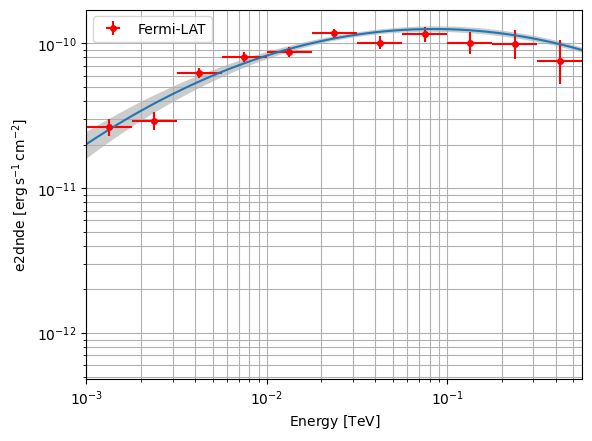

In [46]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)

plt.grid(which="both")
plt.legend()

In [47]:
hess_fpt = analysis.flux_points[1].to_table(sed_type="e2dnde", formatted=True)
hess_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.200,0.158,0.251,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.316,0.251,0.398,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.501,0.398,0.631,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.794,0.631,1.000,5.362e-11,3.516e-12,3.560e-12,3.475e-12,6.083e-11,260.589,16.143,368.9882579956291,313.9865,0.000,False,369.0,True,0.200 .. 5.000,179.448 .. 1195.566
1.259,1.000,1.585,3.905e-11,3.189e-12,3.250e-12,3.130e-12,4.568e-11,175.526,13.249,198.00217332592172,180.00237,0.000,False,198.0,True,0.200 .. 5.000,116.835 .. 849.314
1.995,1.585,2.512,3.323e-11,3.251e-12,3.325e-12,3.179e-12,4.002e-11,121.929,11.042,139.06749121346513,126.0738,0.000,False,139.0,True,0.200 .. 5.000,84.449 .. 508.306
3.162,2.512,3.981,2.269e-11,3.137e-12,3.224e-12,3.059e-12,2.933e-11,59.054,7.685,80.00276271587146,69.00314,0.000,False,80.0,True,0.200 .. 5.000,38.860 .. 317.718


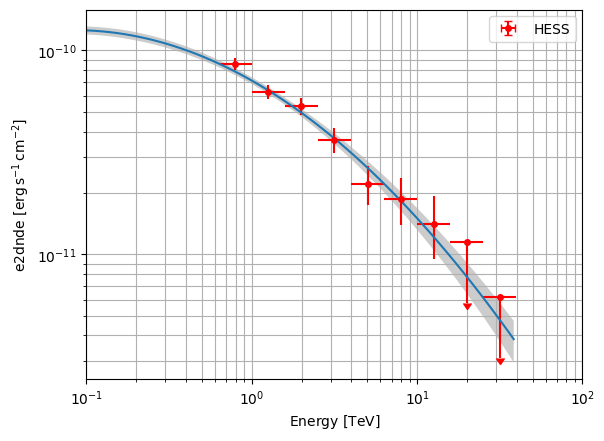

In [50]:
analysis.flux_points[1].plot(sed_type="e2dnde", color="red", label="HESS")
analysis.datasets[1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV]
)
analysis.datasets[1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV]
)

plt.grid(which="both")
plt.legend()

# Final SED plot with all instruments

(0.0007, 50.0)

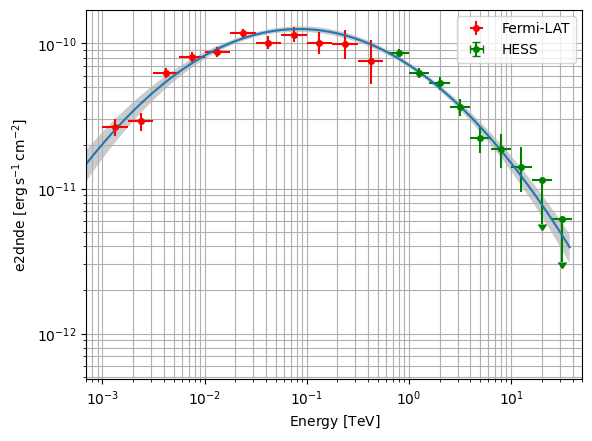

In [52]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.flux_points[1].plot(sed_type="e2dnde", color="green", label="HESS")

analysis.datasets[1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 40 * u.TeV]
)
analysis.datasets[1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 40 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(7e-4, 5e1)